In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from datetime import datetime
import time
import corner
import emcee
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
from ltsfit.lts_linefit import lts_linefit

In [2]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [3]:
# df = pd.read_csv("edd_cf4_refined.csv", sep='|')
df = pd.read_csv("btfr_brent_updated.csv", sep='|')

for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df = df.rename(columns={"e_F21":"eF21"})

df = df.set_index("PGC")
print(df.columns)
print(len(df))

df.head()

Index(['flag', 'DM_av', 'eDM', 'DM_riz', 'eDM_riz', 'DM_W1', 'eDM_W1', 'DM_75',
       '1PGC', 'Nest', 'logMs_riz', 'logMs_W1', 'logM_gas', 'logMb', 'Vhel',
       'Vls', 'v3k', 'f', 'lgWmxi', 'elgWi', 'F21', 'eF21', 'inc', 'einc',
       'g***', 'r***', 'i***', 'z***', 'w1***', 'Qs', 'Qw', 'RA', 'DE',
       'GLong', 'GLat', 'SGL', 'SGB', 'Nkt', 'N15', 'SGLg', 'SGBg', 'Vhg',
       'Vlsg', 'V3kg', 'fg'],
      dtype='object')
10153


,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,SGL,SGB,Nkt,N15,SGLg,SGBg,Vhg,Vlsg,V3kg,fg
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.11,73150,200275.0,...,341.6440,20.7388,0,7,341.4922,20.7395,5194,5486,4916,1.013
4,1,33.49,0.38,33.44,0.19,33.54,0.19,33.72,120,202766.0,...,316.0587,18.4514,0,0,316.0587,18.4514,4458,4706,4109,1.011
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.61,12,210177.0,...,286.4249,11.3511,0,1,286.4249,11.3510,6532,6669,6179,1.016
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.30,16,211419.0,...,287.6119,11.7030,0,1,287.6120,11.7030,5709,5851,5354,1.014
55,1,33.71,0.43,33.70,0.26,33.71,0.25,33.89,55,NaN,...,327.0996,19.7763,0,0,327.0996,19.7763,4779,5052,4454,1.012


In [4]:
df['Vmod'] = df.fg*df.Vlsg   # df.f*df.v3k # 
df['D75'] = df.Vmod / 75.
df['logD75'] = np.log10(df.D75)
df['DM_75'] = 5*df.logD75 + 25 
df['Mg_75'] = df['g***'] - df.DM_75
df['Mr_75'] = df['r***'] - df.DM_75
df['Mi_75'] = df['i***'] - df.DM_75
df['Mz_75'] = df['z***'] - df.DM_75
df['M1_75'] = np.asarray([np.float64(x) for x in df['w1***'].values]) - df.DM_75.values

df['gi'] = df['g***'] - df['i***']

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df_alfa = pd.read_csv("ALFALFA.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)

df_alfa = df_alfa.set_index("PGC")
df_alfa = df_alfa[["F", "e_F"]]
df_alfa.head()

,F,e_F
PGC,,
4,1.96,0.07
6,1.13,0.09
10,2.47,0.06
20,2.30,0.11
28,2.49,0.11


In [6]:
df_adhi = pd.read_csv("ADHI.csv", sep='|')
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)
df_adhi = df_adhi.set_index("PGC")
df_adhi = df_adhi[["Flux"]]

df_adhi.head()

,Flux
PGC,
2,4.73
4,1.85
6,NaN
10,2.47
12,3.40


In [7]:
df = df.join(df_alfa, how='left')
df = df.join(df_adhi, how='left')

df = df.rename(columns={"Vls":"V3k"})

df.head()

,flag,DM_av,eDM,DM_riz,eDM_riz,DM_W1,eDM_W1,DM_75,1PGC,Nest,...,logD75,Mg_75,Mr_75,Mi_75,Mz_75,M1_75,gi,F,e_F,Flux
PGC,,,,,,,,,,,,,,,,,,,,,
2,1,34.57,0.45,NaN,NaN,34.57,0.28,34.349020,73150,200275.0,...,1.869804,NaN,NaN,NaN,NaN,-22.459020,NaN,NaN,NaN,4.73
4,1,33.49,0.38,33.44,0.19,33.54,0.19,34.011709,120,202766.0,...,1.802342,-18.421709,-18.681709,-18.891709,-18.941709,-17.941709,0.47,1.96,0.07,1.85
12,1,35.05,0.41,NaN,NaN,35.05,0.23,34.779466,12,210177.0,...,1.955893,NaN,NaN,NaN,NaN,-21.189466,NaN,NaN,NaN,3.40
16,1,34.70,0.43,34.66,0.26,34.74,0.25,34.491034,16,211419.0,...,1.898207,-20.131034,-20.631034,-20.911034,-21.091034,-20.501034,0.78,NaN,NaN,1.19
55,1,33.71,0.43,33.70,0.26,33.71,0.25,34.167913,55,NaN,...,1.833583,-18.637913,-18.847913,-18.947913,-18.997913,-17.967913,0.31,NaN,NaN,4.30


In [8]:
df['F21_av'] = df[["F", "Flux"]].mean(axis=1)

dg = df[["F21", "eF21", "F", "e_F", "Flux", "F21_av"]]
dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


adhi_list = [5072, 9670, 49734, 51401, 1737674, 3091777, 5807477]
dg.loc[adhi_list]['F21_'] = dg.loc[adhi_list].Flux   # using ADHI HI flux values


len(dg)

# df["F21"] = dg.F21_
# df["eF21"] = dg.F21_e

<ipython-input-8-69eae98da3b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_'] = dg.apply(lambda X: X.F21_av if ~np.isnan(X.F21_av) else X.F21, axis=1)
<ipython-input-8-69eae98da3b9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg['F21_e'] = dg.apply(lambda X: X.e_F if ~np.isnan(X.F) else X.eF21, axis=1)


10153

In [9]:
new_drop = pd.read_csv("drop_january2021.bar", sep='|')

df = df.drop(new_drop.PGC.values, errors='ignore')

len(df)

10153

In [10]:
calib = pd.read_csv("../calibrators/allzpa_labels.csv", sep=',')

for col in calib.columns:
    newcol = col.strip()
    calib.rename(columns={col:newcol}, inplace=True)
    
calib_weird = [68535, 28378, 42081, 39461, 44536]
calib['Name']=calib.apply(lambda x: None if x.PGC in calib_weird else x.Name, axis=1)
            
calib.set_index('PGC', inplace=True)

calib = calib.join(df[["V3k", "Vmod", "Qs", "Qw", "F21", 'eF21', 'elgWi', 'g***', 'r***', 'i***', 'z***']]).dropna()
calib = calib[(calib.Qs>2) & (calib['i']>0)]

calib['Dist'] = 10**((calib.dm19-25)/5.)
calib['Mass_HI'] = 2.356E5 * calib.F21 * (calib.Dist**2)


for waveband in ['g***','r***','i***','z***']:
    calib[waveband] = calib.apply(lambda x: x[waveband] if x[waveband]!=0 else np.nan, axis=1)
for waveband in ['g','r','i','z']:
    calib[waveband+'***'] = calib.apply(lambda x: x[waveband+'***'] if x[waveband]!=0 else np.nan, axis=1)

calib['Mr'] = calib['r***']-calib.dm19
calib['Mi'] = calib['i***']-calib.dm19
calib['Mz'] = calib['z***']-calib.dm19
calib['gi'] = calib["g***"]-calib['i***']


calib['logMs_i']  = 1.619 + 0.510*calib.gi - 0.4*calib['Mi']
calib['logMs_r']  = 1.617 + 0.650*calib.gi - 0.4*calib['Mr']
calib['logMs_z']  = 1.610 + 0.461*calib.gi - 0.4*calib['Mz']

alfa = 0.461
beta = 1.610
calib['logMs_riz'] = calib.logMs_z

calib['Ms_riz'] = 10**calib.logMs_riz
calib = calib.dropna()

print(len(calib))
calib.head()

45


,So,Name,dm19,inc,lgWmxi,eWi,Mu,Mg,Mr,Mi,...,i***,z***,Dist,Mass_HI,gi,logMs_i,logMs_r,logMs_z,logMs_riz,Ms_riz
PGC,,,,,,,,,,,,,,,,,,,,,
21396,2,NGC2403,27.514,58,2.454,0.026,-18.56,-19.43,-19.704,-19.854,...,7.66,7.64,3.182731,3.273213e+09,0.42,9.7748,9.7716,9.75322,9.75322,5.665262e+09
28357,2,NGC3021,32.327,58,2.454,0.022,-19.11,-20.11,-20.617,-20.897,...,11.43,11.30,29.201153,2.535331e+09,0.79,10.3807,10.3773,10.38499,10.38499,2.426554e+10
32192,2,NGC3368,30.165,52,2.630,0.024,-19.29,-20.67,-21.355,-21.715,...,8.45,8.31,10.789467,2.248998e+09,1.04,10.8354,10.8350,10.83144,10.83144,6.783284e+10
32207,2,NGC3370,32.149,56,2.514,0.021,-19.43,-20.22,-20.589,-20.779,...,11.37,11.30,26.902956,4.424994e+09,0.56,10.2162,10.2166,10.20776,10.20776,1.613467e+10
34695,2,NGC3627,30.125,64,2.605,0.015,-20.04,-21.16,-21.715,-21.985,...,8.14,7.99,10.592537,1.206747e+09,0.82,10.8312,10.8360,10.84202,10.84202,6.950563e+10


In [11]:
# calib.loc[26317].head(20)

In [12]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

In [13]:
gamma = np.log10(0.5) + 0.4*5.91
df['logMs_W1'] = gamma - 0.4*df['M1_75']
df['Ms_W1'] = 10**df.logMs_W1

df['Mass_HI'] = 2.356E5 * df.F21 * (df.D75**2)

df['logMs_i']  = 1.619 + 0.510*df.gi - 0.4*df['Mi_75']
df['logMs_r']  = 1.617 + 0.650*df.gi - 0.4*df['Mr_75']
df['logMs_z']  = 1.610 + 0.461*df.gi - 0.4*df['Mz_75']

df['logMs_riz'] = df.logMs_z
df['Ms_riz'] = 10**df.logMs_riz

In [14]:
mc = -5.900811847920911e-05
def HI_corrector(mc, bc, V3k):
    return 0 # mc*V3k+bc

iter:  0
iter:  1


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-15-48d406ddb772>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.
<ipython-input-15-48d406ddb772>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
<ipython-input-15-48d406ddb772>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy 

3.0542935524929256 10.501369239875208


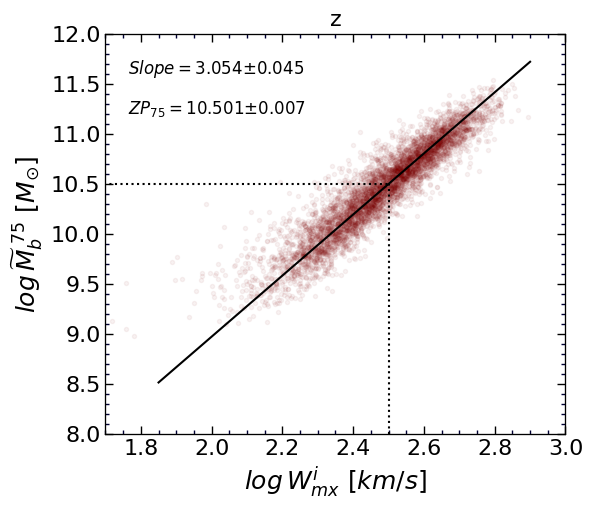

In [15]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

for jj in range(2):
    
    dff = dff[np.abs(dff.delta)<3.5*std].dropna()

    logW = dff.lgWmxi.values
    logWe = dff.elgWi.values
    logMass = dff.logMb.values
    V3k = dff.V3k.values

    ln10 = np.log(10)
    dMs = 0.4*0.05*ln10
    dM21 = 2.356E5 * dff.eF21.values * (dff.D75.values**2)
    dMb = np.sqrt(dMs**2+(1.33**2)*dM21**2)
    Mb = dff.Ms_riz.values + 1.33*(10**(np.log10(dff.Mass_HI.values)))
    dlogMb = dMb/Mb/ln10


    fit, cov = curve_fit(linear, logMass, logW-2.5, sigma=np.sqrt(logWe**2+(0.01)**2))
    m, b = fit[0], fit[1]
    me = np.sqrt(cov[0,0])
    be = np.sqrt(cov[1,1])
    mbe = cov[1,0]    
    m0 = 1./m
    b0 = -b/m
    dm0 = np.abs(me/m**2)
    db0 = np.sqrt((b0**2 )*(be**2/b**2+me**2/m**2-2*mbe/m/b))
    
    
    fit, cov = np.polyfit(logW-2.5, logMass, 1, w=1./(m*logWe), cov=True)
    m = fit[0]
    b = fit[1]
    
#     if jj>0:
#         mcfit = lts_linefit(logW-2.5, logMass, np.sqrt(logWe**2+(0.01)**2), 0.*dlogMb+0.01, clip=3.)    

    dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
    dff['delta'] = m0*(dff.lgWmxi-2.5)+b0 - dff.logMb
    std = dff['delta'].std()
    
    print("iter: ", jj)
    
logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass, '.', color='maroon', alpha=0.05) 


w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + b0, 'k-')
print(m0,b0)    
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{\/\/75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("z", fontsize=16)

Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.95*Xlm[0]+0.05*Xlm[1]
y0 = 0.1*Ylm[0]+0.9*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
y0 = 0.2*Ylm[0]+0.8*Ylm[1]
ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')

ax.plot([2.5,2.5], [8, b0], 'k:')
ax.plot([0,2.5], [b0, b0], 'k:')

3.0542935524929256 10.501369239875208


/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-16-34f3a3f08bb3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


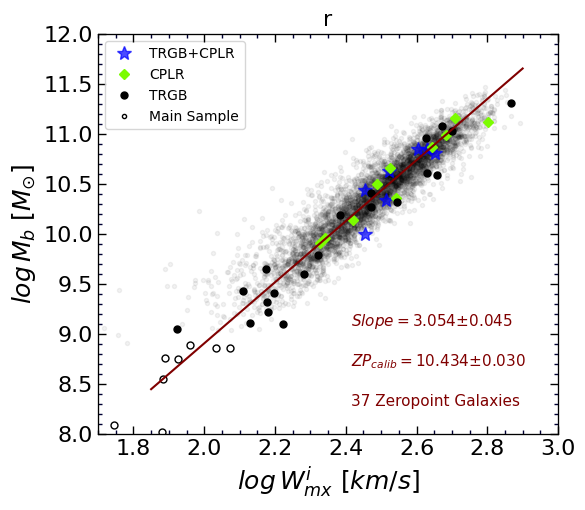

In [16]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

calib['Mb'] = calib.Ms_riz + 1.33*(10**(np.log10(calib.Mass_HI)+HI_corrector(mc, 0, calib.V3k.values)))
calib['logMb'] = np.log10(calib.Mb.values)


dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

##################################################################
def linear_zp(x, zp):
    
    return x/m0+zp

X = calib.lgWmxi.values
Xe = calib.elgWi.values
Y = calib.logMb.values
BB = calib['logMb']
So = calib.So.values

fit, cov = curve_fit(linear_zp, Y[BB>9], X[BB>9]-2.5, sigma=np.sqrt(Xe[BB>9]**2+(0.01)**2))
zp_calib = -fit[0]*m0
zp_calib_e = np.sqrt(cov[0][0])*m0

zp_calib_e = np.sqrt(zp_calib_e**2+db0**2)

zp_calib += 0.05


logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values
ax.plot(logW, logMass-b0+zp_calib, '.', color='k', alpha=0.05) 

ind, = np.where((BB<9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', mfc='white') 
ind, = np.where((BB>9)&(So==2))
ax.plot(X[ind], Y[ind], '*', ms=10, color='blue', alpha=0.7, label='TRGB+CPLR') 


ind, = np.where((BB<9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', mfc='white') 
ind, = np.where((BB>9)&(So==0))
ax.plot(X[ind], Y[ind], 'D', ms=5, color='lawngreen', alpha=1.0, label='CPLR') 


ind, = np.where((BB<9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', mfc='white') 
ind, = np.where((BB>9)&(So==1))
ax.plot(X[ind], Y[ind], 'o', ms=5, color='k', label='TRGB') 

ax.plot([0], [0], '.', color='k', label='Main Sample', mfc='white') 
#######################################################################

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, '-', color='maroon')
print(m0,b0)    

    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$log \/ M_b \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("r", fontsize=16)

# Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
# x0 = 0.95*Xlm[0]+0.05*Xlm[1]
# y0 = 0.1*Ylm[0]+0.9*Ylm[1]
# ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=12, color='k')
# y0 = 0.2*Ylm[0]+0.8*Ylm[1]
# ax.text(x0,y0, r"$ZP_{75} = $"+"%.3f" % b0+'$\pm$'+"%.3f" % db0, fontsize=12, color='k')


Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
x0 = 0.45*Xlm[0]+0.55*Xlm[1]
y0 = 0.93*Ylm[0]+0.07*Ylm[1]
ax.text(x0,y0, "%d"%len(Xe[BB>9])+' Zeropoint Galaxies', fontsize=11, color='maroon')
y0 = 0.83*Ylm[0]+0.17*Ylm[1]
ax.text(x0,y0, r"$ZP_{calib} = $"+"%.3f" % zp_calib+'$\pm$'+"%.3f" % zp_calib_e, fontsize=11, color='maroon')
y0 = 0.73*Ylm[0]+0.27*Ylm[1]
ax.text(x0,y0, r"$Slope = $"+"%.3f" % m0+'$\pm$'+"%.3f" % dm0, fontsize=11, color='maroon')

ax.legend(loc=2)

In [17]:
np.std(Y[(Y<11.5)&(Y>9.0)] - (m0*(X[(Y<11.5)&(Y>9.0)]-2.5) + zp_calib))

0.17924788144988868

In [18]:
std

10000000000.0

In [19]:
b0 = zp_calib
b0

10.434247479407608

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-20-85d3970b3e1f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['delta'] = 0.


718
758
53


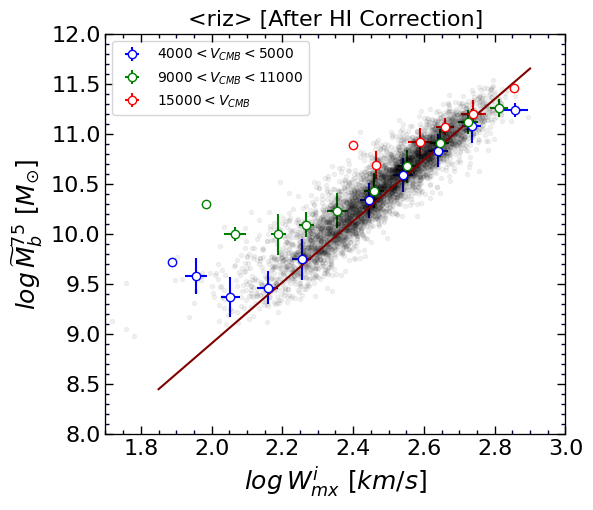

In [20]:
df['Mb'] = df.Ms_riz + 1.33*(10**(np.log10(df.Mass_HI)+HI_corrector(mc, 0, df.V3k.values)))
df['logMb'] = np.log10(df.Mb.values)

dff = df[(df.Qs>2)&(df.elgWi>0)&(df.lgWmxi>0)&(df.V3k>4000)]
std = 1.E10
dff['delta'] = 0.
    

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values

fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

ax.plot(logW, logMass, 'k.', alpha=0.05) 

X0 = logW
Y0 = logMass
V3k = dff.V3k.values
label=r'$4000<V_{CMB}<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)       
        
        
label=r'$9000<V_{CMB}<11000$'
ind, = np.where((V3k>9000)&(V3k<11000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)      
   

        
label=r'$15000<V_{CMB}$'
ind, = np.where((V3k>15000)&(V3k<20000))
X = X0[ind]
Y = Y0[ind]
print(len(X))
lab = True
for i in np.arange(1.8,2.9,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)   
    
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b^{75} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (8,12))

ax.set_title("<riz> [After HI Correction]", fontsize=16)

ax.legend()

ax.plot(w, m0*(w-2.5) + b0, '-', color='maroon')

In [21]:
m0, b0, alfa, beta

(3.0542935524929256, 10.434247479407608, 0.461, 1.61)

In [22]:
def getDM(mag_r, mag_i, mag_z, Wlog, F21, m0, b0, D, gi, V3k):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
        
    alfa = 0.461
    beta = 1.610
    logXriz = beta + alfa*gi
    
    Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
    
    if mag_z>0 :
        DM = mag_z - Mag_riz
    else:
        return np.nan

    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [23]:
def getDM_simul(D, mag, gi, Wlog, F21, alfa, beta, MtoLscatter, slope, zp, V3k, mc):
    
    Mb = 10**(slope*(Wlog-2.5)+zp)
    
    M21 = 2.356E5 * F21 * (D**2)
    M21 = 10**(np.log10(M21) + mc*V3k)
    
    logX = beta + alfa*gi   
    Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
       
    DM = mag - Mag
    D = 10**((DM-25)/5)
    
    return D

npzName = "MLratio_z_gi.npz"
npzfile = np.load(npzName)
samples_ = npzfile['arr_0']
samples_ = samples_[np.where(samples_[:,0]>0)]
samples_ = samples_[(samples_[:,1]>1.56)&(samples_[:,1]<2)]
samples_ = samples_[np.where(samples_[:,3]>10.25)]

alfaPool = samples_[:,0]
betaPool = samples_[:,1]
slopePool = samples_[:,2]
meanZP = np.mean(samples_[:,3])
zpPool = samples_[:,3]-meanZP+b0

n, m = samples_.shape

Nsimul = 300

In [24]:
t1 =  datetime.now()
print(t1)

dff = df[(df.Qs>0)&(df.elgWi>0)&(df.lgWmxi>0)]
Wlog = dff.lgWmxi.values
eWlog = dff.elgWi.values
F21 = dff.F21.values
eF21 = dff.eF21.values
D75 = dff.D75.values
gi = dff.gi.values
V3k = dff.V3k.values
PGC = dff.index.values
mag_r = dff["r***"].values
mag_i = dff["i***"].values
mag_z = dff["z***"].values


N = len(dff)
DM_fid = np.zeros(N) + np.nan
eDM_fid = np.zeros(N) + np.nan
DMav_fid = np.zeros(N) + np.nan
print(N)
pp=0


for j in range(N): # range(50): #
    
    if mag_r[j]>0 and mag_i[j]>0 and mag_z[j]>0:
        D = np.arange(0.5,800,0.5)

        delta =  D - getDM(mag_r[j], mag_i[j], mag_z[j], Wlog[j], F21[j], m0, b0, D, gi[j], V3k[j])

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            print("flag (j, pgc): ", j, PGC[j])
            pp+=1
        if j%1000==0:
            print(j, datetime.now())
    else:
        print("flag (j, pgc, nan): ", j, PGC[j])
        D_root = np.nan
        
    ## uncertainty calucaltion unit
    try:
        DMsimuls = np.zeros(Nsimul) + np.nan
        for i in range(Nsimul):
            try:

                jj = np.random.randint(n)
                D = np.arange(0.5,800,0.5)
                delta = D - getDM_simul(D, \
                                  np.random.normal(mag_z[j], 0.07), \
                                  np.random.normal(gi[j], 0.1), \
                                  np.random.normal(Wlog[j], eWlog[j]), \
                                  np.random.normal(F21[j], eF21[j]), \
                                  alfaPool[jj], betaPool[jj], \
                                  np.random.normal(0, 0.07), \
                                  slopePool[jj], np.random.normal(zpPool[jj], 0.04), \
                                  V3k[j], \
                                  np.random.normal(mc, 7.03018543e-07))
                D = D[~np.isnan(delta)]
                delta = delta[~np.isnan(delta)]
                try:
                    D0 = interpol(D, delta)
                    DMsimuls[i] = 5*np.log10(D0)+25
                except:
                    D0 = np.max(D[delta<0])
                    DMsimuls[i] = 5*np.log10(D0)+25
            except:
                pass    


        eDM_fid[j]  = np.std(DMsimuls)
        DMav_fid[j] = np.mean(DMsimuls)
#         print("pgc, DM, DMav, eDM : ", j, PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])
#         print("   ", Wlog[j], eWlog[j], F21[j], eF21[j], V3k[j], gi[j])
        
    except:
        pass
       

print("Number of concerning distances:", pp)

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

2021-08-11 18:21:36.711123
7096
0 2021-08-11 18:21:36.719268


<ipython-input-22-5ccd78071b05>:12: RuntimeWarning: invalid value encountered in log10
  Mag_riz = -2.5*(np.log10(Mb - 1.33*M21) - logXriz)
<ipython-input-23-58669e17f2e7>:9: RuntimeWarning: invalid value encountered in log10
  Mag  = -2.5*(np.log10(Mb - 1.33*M21) - logX)
<ipython-input-23-58669e17f2e7>:6: RuntimeWarning: invalid value encountered in log10
  M21 = 10**(np.log10(M21) + mc*V3k)


1000 2021-08-11 18:24:51.244223
flag (j, pgc, nan):  1317 23362
flag (j, pgc, nan):  1549 26317


<ipython-input-22-5ccd78071b05>:6: RuntimeWarning: divide by zero encountered in log10
  M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))


flag (j, pgc, nan):  1756 28630
2000 2021-08-11 18:28:18.120101
flag (j, pgc, nan):  2966 42089
3000 2021-08-11 18:31:18.979970
flag (j, pgc, nan):  3702 51664
4000 2021-08-11 18:34:38.405851
flag (j, pgc, nan):  4261 57627
5000 2021-08-11 18:38:15.029935
6000 2021-08-11 18:41:52.334001
7000 2021-08-11 18:44:56.461304
Number of concerning distances: 0
Execution time:
0:23:36.074772


In [25]:
for j in range(N):
    
    if np.abs(DM_fid[j]-DMav_fid[j]) > 0.1:
        print(PGC[j], "%.2f"%DM_fid[j], "%.2f"%DMav_fid[j], "%.2f"%eDM_fid[j])

55 33.60 33.86 0.25
68 34.70 34.84 0.42
70 34.93 35.32 0.16
76 34.55 34.78 0.19
92 32.80 32.92 0.19
96 36.20 36.60 0.19
102 34.17 34.36 0.16
124 34.29 34.57 0.16
128 35.44 36.03 0.25
165 34.70 34.94 0.18
176 34.96 35.16 0.27
186 34.98 35.30 0.21
201 35.05 35.19 0.31
205 34.80 35.09 0.26
212 36.05 36.47 0.18
216 33.93 34.11 0.22
218 31.59 31.75 0.17
222 35.03 35.59 0.19
247 36.76 37.12 0.30
250 34.15 34.38 0.26
257 34.88 35.35 0.15
258 35.78 36.13 0.17
259 34.66 34.84 0.24
279 32.30 32.41 0.17
298 33.66 33.82 0.26
301 34.10 34.23 0.17
303 33.42 33.59 0.25
312 33.26 33.37 0.27
329 33.97 34.31 0.25
345 34.15 34.60 0.34
354 34.50 34.75 0.30
366 34.62 34.81 0.34
415 34.88 35.09 0.23
431 34.37 34.68 0.17
465 35.71 35.93 0.28
496 30.82 30.39 0.25
507 34.83 35.02 0.20
559 34.12 34.31 0.17
567 35.07 35.25 0.22
569 34.28 34.50 0.17
613 34.54 34.72 0.25
616 35.66 35.99 0.30
642 34.61 34.78 0.22
644 33.74 33.89 0.30
650 33.86 34.03 0.18
657 35.61 35.85 0.35
658 34.63 34.86 0.17
690 34.64 34.90 0.2

6889 33.15 33.33 0.16
6893 33.71 33.94 0.24
6905 34.49 34.84 0.15
6966 34.34 34.63 0.15
6982 33.74 33.91 0.17
6996 35.50 35.74 0.36
7039 33.64 33.90 0.21
7072 33.42 33.30 0.40
7073 34.39 34.52 0.20
7087 33.71 33.59 0.41
7088 34.21 34.41 0.15
7098 34.31 34.49 0.17
7104 33.95 34.10 0.18
7150 34.43 34.59 0.18
7222 33.44 33.28 0.18
7243 34.29 34.46 0.17
7246 35.32 35.47 0.31
7259 34.16 34.42 0.23
7281 35.72 36.44 0.19
7285 34.73 35.00 0.21
7306 33.57 33.74 0.19
7328 34.61 34.81 0.21
7341 35.47 35.75 0.20
7354 34.18 34.31 0.27
7366 34.63 34.82 0.24
7377 34.35 34.49 0.28
7384 34.18 34.29 0.21
7406 33.48 33.66 0.16
7411 33.66 34.02 0.13
7420 34.50 34.64 0.17
7441 33.82 34.08 0.16
7442 33.70 33.82 0.18
7465 34.16 34.43 0.25
7519 36.35 36.67 0.21
7521 32.78 32.61 0.46
7537 33.79 33.90 0.25
7547 34.20 34.34 0.30
7574 35.26 35.48 0.28
7594 34.51 34.65 0.19
7596 34.22 34.49 0.19
7604 34.83 34.98 0.28
7613 32.56 32.46 0.30
7637 35.03 35.49 0.23
7653 34.36 34.50 0.42
7663 32.75 32.58 0.18
7671 27.71

22389 33.84 33.98 0.16
22392 36.04 36.43 0.18
22394 35.19 35.39 0.27
22401 35.07 35.22 0.25
22413 34.67 34.81 0.18
22419 35.43 35.74 0.20
22443 35.26 35.53 0.21
22506 34.14 34.34 0.17
22509 36.69 37.19 0.18
22542 35.40 35.68 0.18
22565 33.92 34.06 0.20
22596 34.01 34.11 0.33
22606 35.98 36.41 0.59
22611 34.19 34.34 0.25
22618 34.27 34.39 0.32
22630 33.48 33.32 0.44
22640 32.45 32.28 0.36
22646 35.58 35.85 0.37
22655 33.64 33.83 0.17
22689 35.01 35.22 0.25
22693 34.34 34.49 0.17
22695 34.43 34.65 0.31
22698 34.86 35.06 0.24
22706 34.99 35.12 0.27
22722 35.12 35.48 0.24
22733 35.62 35.89 0.28
22751 31.20 30.84 0.51
22752 34.74 34.86 0.32
22758 34.04 34.23 0.21
22778 34.20 34.39 0.22
22796 35.59 35.88 0.21
22802 35.19 35.54 0.29
22835 35.48 35.79 0.21
22896 34.77 34.99 0.23
22909 34.63 34.89 0.23
22921 33.37 33.65 0.14
22965 34.50 34.76 0.20
22994 35.73 35.99 0.23
23014 33.65 33.84 0.34
23017 34.53 34.69 0.26
23018 34.49 34.64 0.27
23026 32.70 32.60 0.42
23033 35.09 35.47 0.15
23069 34.33

34419 31.61 31.40 0.21
34454 34.79 35.00 0.21
34459 33.98 34.11 0.30
34468 35.68 36.21 0.16
34471 34.25 34.37 0.16
34495 34.98 35.19 0.18
34501 32.33 32.18 0.28
34529 32.58 32.45 0.19
34541 34.78 35.07 0.19
34546 34.72 34.96 0.40
34568 34.78 35.13 0.17
34595 35.21 35.34 0.26
34612 30.67 30.88 0.17
34623 34.39 34.71 0.15
34629 34.07 33.93 0.50
34632 34.00 34.23 0.22
34644 35.67 35.93 0.28
34653 30.98 30.40 0.90
34681 35.29 35.52 0.20
34683 31.83 31.52 0.21
34697 30.47 30.62 0.17
34717 34.28 34.45 0.30
34757 34.69 34.95 0.20
34763 34.74 34.93 0.19
34770 35.53 35.80 0.20
34814 34.80 35.01 0.17
34824 35.47 35.70 0.31
34836 33.64 33.99 0.21
34837 35.22 35.51 0.21
34887 31.94 31.63 0.21
34913 35.06 35.29 0.19
34921 36.03 36.50 0.28
34929 31.81 31.63 0.21
34971 31.91 31.70 0.22
34996 35.00 35.28 0.31
35017 35.20 35.45 0.18
35018 35.11 35.41 0.20
35019 35.68 36.03 0.17
35037 35.66 36.02 0.18
35061 34.10 34.22 0.16
35080 33.33 33.19 0.47
35083 34.58 34.73 0.18
35088 31.97 32.13 0.20
35123 34.68

39028 31.14 31.31 0.16
39038 36.04 36.48 0.26
39046 34.46 34.65 0.15
39050 32.93 32.75 0.28
39051 34.87 35.07 0.17
39052 32.14 31.86 0.50
39099 34.65 34.86 0.17
39101 34.85 35.21 0.18
39109 32.72 32.56 0.23
39113 32.00 31.67 0.19
39143 31.36 31.14 0.23
39177 35.90 36.29 0.20
39181 32.41 32.07 0.26
39191 30.82 30.44 0.39
39206 30.83 30.63 0.18
39230 30.06 29.53 0.38
39232 35.65 36.10 0.19
39237 31.21 30.92 0.41
39245 34.71 34.95 0.23
39246 31.41 31.61 0.16
39256 28.88 28.28 0.92
39265 32.15 31.91 0.26
39289 35.24 35.48 0.16
39306 35.99 36.34 0.26
39308 31.46 31.33 0.17
39316 28.34 27.58 0.71
39321 34.34 34.47 0.17
39323 35.72 36.06 0.18
39328 33.27 33.47 0.21
39342 34.52 34.77 0.31
39344 31.81 31.56 0.36
39400 34.69 34.95 0.26
39407 34.43 34.61 0.17
39422 28.59 28.41 0.19
39423 29.11 28.82 0.39
39431 30.25 29.71 0.25
39432 31.43 31.31 0.14
39440 34.78 35.18 0.14
39449 34.73 34.95 0.18
39458 34.83 35.17 0.21
39461 28.86 28.42 0.65
39473 35.08 35.27 0.33
39479 33.44 33.63 0.21
39519 34.24

45937 34.76 35.04 0.22
45938 34.12 34.27 0.25
45939 28.45 27.74 0.94
45943 35.55 35.69 0.25
45947 34.91 35.21 0.24
45948 31.36 31.54 0.28
45959 34.95 35.23 0.17
45967 35.04 35.26 0.39
46028 34.48 34.61 0.18
46045 34.41 34.57 0.61
46075 34.72 34.91 0.26
46089 34.64 34.89 0.17
46121 35.04 35.33 0.17
46124 34.97 35.19 0.15
46127 28.30 27.64 0.44
46145 33.81 33.95 0.20
46153 29.43 29.57 0.21
46159 31.21 30.92 0.19
46164 34.78 35.15 0.16
46171 34.67 34.96 0.18
46180 34.31 34.58 0.23
46189 35.10 35.34 0.25
46249 34.99 35.41 0.18
46262 34.68 35.08 0.29
46293 33.95 34.08 0.24
46302 34.43 34.67 0.19
46321 34.55 34.83 0.20
46388 35.52 35.88 0.20
46427 34.96 35.29 0.19
46449 34.16 34.38 0.33
46534 36.29 36.72 0.19
46556 30.53 30.08 0.30
46563 31.52 31.31 0.22
46617 33.55 33.68 0.26
46636 31.55 31.39 0.22
46641 36.12 36.45 0.18
46644 35.77 36.16 0.24
46649 35.24 35.46 0.18
46658 35.21 35.34 0.22
46671 31.05 30.95 0.27
46715 34.70 34.86 0.17
46726 34.55 34.88 0.21
46731 35.15 35.34 0.17
46739 30.66

52235 34.48 34.77 0.41
52248 34.90 35.25 0.19
52258 34.13 34.30 0.17
52266 32.85 32.98 0.18
52279 34.61 34.80 0.23
52280 34.62 34.75 0.18
52308 34.90 35.12 0.33
52320 35.34 35.57 0.47
52328 34.93 35.36 0.29
52333 35.01 35.37 0.22
52343 33.69 33.81 0.19
52350 35.16 35.32 0.33
52361 36.31 36.82 0.23
52376 35.08 35.30 0.25
52380 35.57 35.97 0.16
52390 34.05 34.27 0.22
52417 35.07 35.30 0.24
52419 36.04 36.31 0.32
52444 35.32 35.97 0.22
52449 35.69 36.00 0.16
52455 31.75 31.86 0.18
52456 32.35 32.18 0.30
52500 32.51 32.34 0.30
52504 35.27 35.58 0.17
52511 34.71 34.94 0.20
52519 35.39 35.66 0.22
52532 34.78 35.03 0.17
52565 36.23 36.57 0.20
52567 35.42 35.92 0.20
52570 34.07 33.92 0.43
52574 32.50 32.35 0.17
52582 35.09 35.37 0.30
52602 35.24 35.69 0.16
52605 34.20 34.57 0.17
52624 34.55 34.88 0.17
52630 34.37 34.57 0.28
52632 35.48 35.83 0.16
52635 34.55 34.71 0.17
52641 32.46 32.57 0.22
52665 32.52 32.80 0.17
52670 35.28 35.66 0.17
52712 35.40 35.70 0.17
52713 33.47 33.62 0.36
52724 35.22

57390 35.10 35.43 0.21
57396 34.90 35.05 0.38
57417 35.53 35.78 0.23
57430 35.10 35.35 0.22
57445 35.95 36.30 0.48
57463 34.89 35.34 0.18
57478 33.90 34.07 0.35
57498 35.63 35.95 0.23
57499 34.87 35.24 0.16
57505 35.18 35.61 0.25
57508 34.32 34.44 0.44
57513 35.92 36.34 0.20
57522 31.83 31.54 0.27
57529 35.10 35.23 0.31
57538 36.01 36.23 0.22
57557 35.11 35.21 0.32
57575 35.79 36.13 0.20
57582 32.53 32.65 0.15
57585 36.04 36.30 0.29
57601 34.91 35.39 0.25
57608 34.66 34.95 0.20
57623 35.16 35.41 0.23
57641 34.60 34.83 0.17
57654 34.74 34.95 0.25
57658 35.04 35.36 0.20
57694 35.25 35.65 0.17
57752 35.38 35.58 0.31
57766 35.53 35.75 0.21
57823 35.50 35.68 0.23
57827 35.54 35.86 0.17
57833 35.54 35.83 0.35
57918 35.57 35.92 0.20
57922 35.33 35.58 0.28
57941 35.81 36.15 0.25
57959 35.31 35.74 0.27
57968 35.41 35.74 0.21
57992 36.83 37.23 0.20
58002 34.02 34.26 0.17
58031 36.34 36.73 0.26
58050 36.40 36.84 0.24
58053 35.50 35.81 0.30
58055 34.82 35.06 0.17
58059 35.83 36.06 0.21
58104 35.27

69287 34.68 34.97 0.25
69299 35.64 36.07 0.18
69316 36.02 36.36 0.21
69325 35.37 35.60 0.27
69327 30.60 30.82 0.17
69336 36.55 37.01 0.22
69347 33.11 33.22 0.64
69351 34.32 34.61 0.20
69372 36.48 36.82 0.27
69394 37.63 38.29 0.25
69402 34.88 35.02 0.27
69417 36.02 36.28 0.25
69428 34.76 35.00 0.16
69429 34.63 34.92 0.17
69433 34.82 35.02 0.31
69450 34.57 34.72 0.26
69452 34.54 34.68 0.48
69456 35.05 35.31 0.18
69460 34.67 34.94 0.18
69463 34.66 35.01 0.23
69469 34.12 34.37 0.16
69473 35.50 35.78 0.18
69502 35.23 35.42 0.25
69529 35.56 35.91 0.25
69530 35.50 35.78 0.24
69544 34.81 35.11 0.27
69553 34.92 35.14 0.31
69559 36.09 36.53 0.23
69588 36.98 37.46 0.19
69594 36.05 36.37 0.25
69597 34.86 35.05 0.17
69608 34.95 35.21 0.22
69612 35.72 35.93 0.34
69616 34.34 34.68 0.27
69699 35.37 35.56 0.33
69718 34.90 35.10 0.22
69731 35.51 35.89 0.36
69739 35.08 35.37 0.16
69765 34.53 34.92 0.25
69770 34.91 35.29 0.24
69771 35.30 35.54 0.23
69774 34.77 35.03 0.20
69787 35.66 35.94 0.19
69794 36.01

84011 35.49 35.76 0.18
84220 35.93 36.51 0.24
84262 36.07 36.37 0.25
84309 35.80 36.14 0.34
84619 33.59 33.32 0.72
85295 35.18 35.52 0.25
85302 34.53 34.86 0.20
85357 35.61 35.95 0.24
85406 35.19 35.52 0.20
85429 32.90 32.71 0.24
85483 32.79 32.92 0.36
85500 33.83 33.96 0.24
85512 35.52 35.68 0.31
85551 35.39 35.55 0.22
85605 34.82 35.24 0.23
85607 35.33 35.52 0.17
85636 33.85 34.08 0.18
85641 34.43 34.73 0.18
85694 35.35 35.56 0.30
85775 34.59 34.73 0.26
85811 34.45 34.78 0.21
85886 35.12 35.33 0.21
85903 35.38 35.81 0.30
85905 34.81 35.11 0.16
85920 35.70 36.12 0.24
85936 34.84 35.12 0.23
85958 35.98 36.23 0.39
86292 34.46 34.73 0.20
86367 35.36 35.67 0.18
86383 35.20 35.63 0.18
86440 35.27 35.57 0.19
86484 34.47 34.57 0.26
86515 34.34 34.69 0.16
86554 34.87 35.14 0.26
86620 33.96 34.12 0.25
86621 35.15 35.27 0.30
86638 34.68 35.00 0.18
86647 34.90 35.23 0.23
86651 35.15 35.42 0.17
86688 33.00 32.89 0.18
86840 34.37 34.62 0.36
86944 35.72 36.15 0.24
87026 33.26 33.13 0.21
87155 35.74

213850 34.35 34.52 0.23
213995 30.06 29.32 0.52
214284 34.95 35.31 0.19
214810 35.11 35.32 0.38
214823 35.17 35.29 0.31
1028254 33.98 34.32 0.28
1035502 34.65 34.80 0.32
1053505 35.12 35.44 0.32
1116432 35.95 36.16 0.31
1129847 34.51 34.62 0.38
1151160 33.23 33.08 0.19
1151996 35.10 35.49 0.24
1153558 34.34 34.78 0.16
1153672 34.19 34.46 0.24
1153756 34.65 35.28 0.46
1153797 35.07 35.61 0.29
1154022 30.74 30.32 0.24
1154025 35.42 35.88 0.21
1154069 35.22 36.18 0.35
1154760 36.50 37.17 0.16
1156115 34.64 34.96 0.49
1156494 34.82 35.09 0.17
1157623 35.04 35.32 0.20
1159724 35.02 35.51 0.19
1167440 34.18 34.40 0.26
1168774 35.80 36.35 0.45
1173723 34.41 34.52 0.19
1174982 35.53 36.18 0.18
1177602 33.05 32.92 0.18
1177883 32.64 33.08 1.58
1179309 34.23 34.81 0.39
1180028 35.05 35.38 0.21
1180309 34.97 35.41 0.20
1180802 31.39 30.98 0.37
1180903 33.10 32.97 0.20
1181973 34.96 35.10 0.31
1186594 34.32 34.69 0.24
1189082 34.85 35.39 0.16
1189777 33.22 33.06 0.29
1189808 34.60 34.86 0.16
11941

1583149 35.06 35.28 0.35
1590644 34.70 35.35 0.16
1592138 35.19 35.60 0.16
1595534 35.37 35.62 0.17
1600590 35.78 36.35 0.19
1602173 35.73 36.08 0.19
1603547 35.30 35.99 0.26
1604583 34.66 35.11 0.16
1605910 34.78 35.10 0.19
1612390 35.43 35.81 0.62
1614069 34.12 33.96 0.24
1615646 36.15 36.61 0.42
1616133 34.93 35.09 0.18
1617626 34.85 35.15 0.18
1618163 35.82 36.27 0.17
1620325 34.82 35.34 0.30
1621290 34.54 34.86 0.15
1624546 35.06 35.21 0.19
1626241 35.02 35.40 0.19
1626466 33.90 34.01 0.34
1627800 35.26 35.78 0.19
1627904 34.78 34.96 0.21
1629210 35.54 35.90 0.18
1629838 34.28 34.39 0.17
1631975 35.78 36.22 0.20
1632187 34.35 34.76 0.25
1633497 34.23 34.45 0.18
1633695 34.70 34.85 0.17
1633897 34.92 35.28 0.22
1634338 35.95 37.07 0.15
1634503 34.05 34.33 0.24
1634766 34.98 35.25 0.18
1635828 35.37 35.69 0.18
1636363 34.09 34.47 0.15
1636696 34.75 34.86 0.23
1640560 35.86 36.62 0.25
1645554 35.25 35.49 0.21
1646351 34.51 34.80 0.15
1646525 34.83 35.23 1.36
1647531 34.33 34.56 0.22


3614452 34.63 34.73 0.29
3614979 34.76 35.20 0.17
3617258 35.39 35.80 0.27
3632079 33.98 34.09 0.18
3634554 34.90 35.07 0.17
3634753 35.60 35.97 0.16
3635175 35.44 35.75 0.19
3636094 35.82 36.24 0.22
3637026 36.41 36.80 0.34
3646720 34.70 34.87 0.22
3648277 34.17 34.34 0.16
3650072 36.10 36.95 0.41
3650221 35.44 35.79 0.17
3725225 36.31 37.16 0.17
3752756 35.96 36.64 0.23
3763365 35.51 36.00 0.25
3764259 34.40 34.76 0.15
3765098 36.27 36.66 0.19
3813296 34.81 35.17 0.16
3834782 36.15 36.62 0.35
3843701 35.71 36.24 0.17
3859893 35.52 36.13 0.15
3951695 35.48 35.95 0.34
3961580 35.49 36.05 0.27
3965132 35.69 36.13 0.41
3969685 35.42 35.66 0.27
3970122 35.56 36.22 0.26
3975944 35.48 36.09 0.16
3976900 35.07 35.66 0.16
3977434 35.69 36.01 0.16
3977968 35.11 35.58 0.21
3979989 35.91 36.30 0.27
3981108 35.15 35.46 0.28
3982612 34.39 34.53 0.32
3983813 33.44 33.69 0.21
3985243 34.49 34.63 0.19
3987653 35.97 36.48 0.16
3988227 34.83 35.00 0.42
3989642 34.64 34.95 0.25
3991829 35.15 35.36 0.28


5808782 32.74 32.44 0.26
5912258 32.25 31.96 0.27
5912271 31.50 31.36 0.20
5950874 34.19 34.54 0.14
5950879 33.99 34.15 0.32
5952558 34.44 34.65 0.19
5952607 35.79 36.09 0.18
5952956 35.44 35.80 0.18
6657028 32.28 32.12 0.30
6719321 32.05 31.83 0.27
6724069 33.65 34.04 0.29


sig_int:     0.0000         inf
Computing sig_int
sig_int:     0.0000   1502.3152
sig_int: 3714602790490459813098792179078266880.0000     -1.0000
sig_int: 3712131849774389722689327088445423616.0000     -1.0000
sig_int: 1856065924887194861344663544222711808.0000     -1.0000
sig_int: 928032962443597430672331772111355904.0000     -1.0000
sig_int: 464016481221798715336165886055677952.0000     -1.0000
sig_int: 232008240610899357668082943027838976.0000     -1.0000
sig_int: 116004120305449678834041471513919488.0000     -1.0000
sig_int: 58002060152724839417020735756959744.0000     -1.0000
sig_int: 29001030076362419708510367878479872.0000     -1.0000
sig_int: 14500515038181209854255183939239936.0000     -1.0000
sig_int: 7250257519090604927127591969619968.0000     -1.0000
sig_int: 3625128759545302463563795984809984.0000     -1.0000
sig_int: 1812564379772651231781897992404992.0000     -1.0000
sig_int: 906282189886325615890948996202496.0000     -1.0000
sig_int: 453141094943162807945474498101248.00

RuntimeError: Failed to converge after 100 iterations.

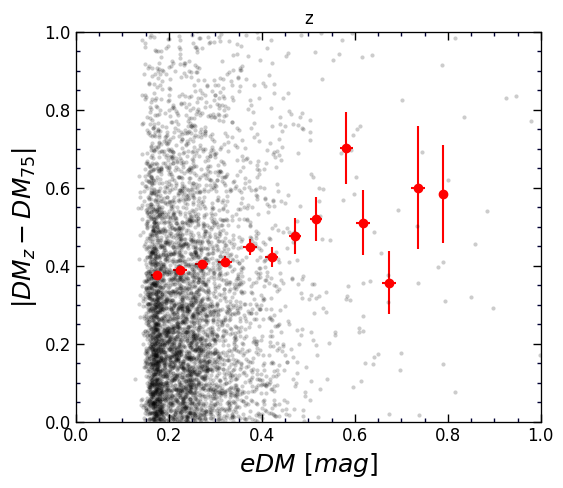

In [33]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = eDM_fid
Y = np.abs(DMav_fid - dff.DM_75.values)

V3k = dff.V3k.values
X = X[V3k>4000]
Y = Y[V3k>4000]

X = X[Y>0]
Y = Y[Y>0]
Y = Y[X>0]
X = X[X>0]



ax.plot(X, Y, 'k.', alpha=0.2, mfc='k', mec='none')

X = X[Y<1]
Y = Y[Y<1]

factor = np.sqrt(np.pi/2.)
for i in np.arange(0.15,0.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        xp = np.asarray(xp)
        yp = np.asarray(yp)
        yp *= factor
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.std(yp)/np.sqrt(len(yp)), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)       
        
ax.set_ylabel(r'$|DM_{z} - DM_{75}|$', fontsize=18)
ax.set_xlabel(r'$eDM \/\/ [mag]$', fontsize=18)

# ax.plot([0,1], [0,0], ':', color='k')

set_axes(ax, (0,1), (0,1), fontsize=12)

ax.set_title("z")

from ltsfit.lts_linefit import lts_linefit
mcfit = lts_linefit(X, factor*Y, X*0+0.001, Y*0+0.001, clip=2., plot=False)
xx = np.linspace(0.15,0.9,100)
ax.plot(xx, mcfit.ab[1]*xx+mcfit.ab[0], '--', color='red')

yy0 = np.mean(factor*Y)
ax.plot([0,1],[yy0,yy0], ':', color='red')
ax.plot([0,1],[0,1], '--', color='#1f77b4')

In [27]:
help(lts_linefit)

Help on class lts_linefit in module ltsfit.lts_linefit:

class lts_linefit(builtins.object)
 |  lts_linefit(x0, y, sigx, sigy, clip=2.6, epsy=True, label='Fitted', label_clip='Clipped', frac=None, pivot=0, plot=True, text=True, corr=True)
 |  
 |  LTS_LINEFIT
 |  -----------
 |  
 |  Purpose
 |  -------
 |  
 |  Best straight-line *robust* fit to data with errors in
 |  both coordinates while fitting for the intrinsic scatter.
 |  See `Cappellari et al. (2013a, Sec.3.2)
 |  <https://ui.adsabs.harvard.edu/abs/2013MNRAS.432.1709C>`_
 |  
 |  Explanation
 |  -----------
 |  
 |  Linear Least-squares approximation in one-dimension (y = a + b*x),
 |  when both x and y data have errors and allowing for intrinsic
 |  scatter in the relation.
 |  
 |  Outliers are iteratively clipped using the extremely robust
 |  FAST-LTS technique by `Rousseeuw & van Driessen (2006)
 |  <http://dx.doi.org/10.1007/s10618-005-0024-4>`_
 |  (See also `Rousseeuw 1987)
 |  <http://books.google.co.uk/books?id=woaH

Text(0.5, 1.0, 'z')

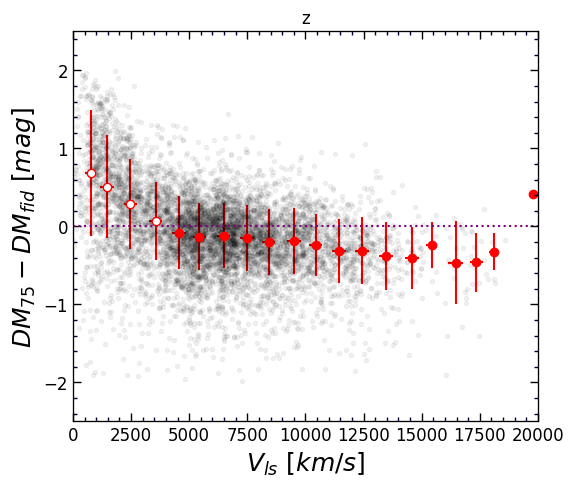

In [34]:
dff['dDM'] = DM_fid - dff.DM_75.values
dff['DMriz_fid'] = DM_fid
dff['DMav_z'] = DMav_fid
dff['eDM_z'] = eDM_fid
eDM_adj = 0.18975218*eDM_fid+0.34702629
for jj in range(len(eDM_fid)):
    if eDM_fid[jj]>eDM_adj[jj]:
        eDM_adj[jj]=eDM_fid[jj]
dff['eDM_z_adj'] = eDM_adj

fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.V3k.values
Y = dff.dDM.values
# logW = dff.lgWmxi.values

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   


for i in np.arange(0,4000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')   
        
        
ax.set_xlabel(r'$V_{ls} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='purple')

set_axes(ax, (0,20000), (-2.5,2.5), fontsize=12)

ax.set_title("z")

In [35]:
np.mean(Y[X>4000])

-0.20231248440064634

Text(0.5, 1.0, '<riz>')

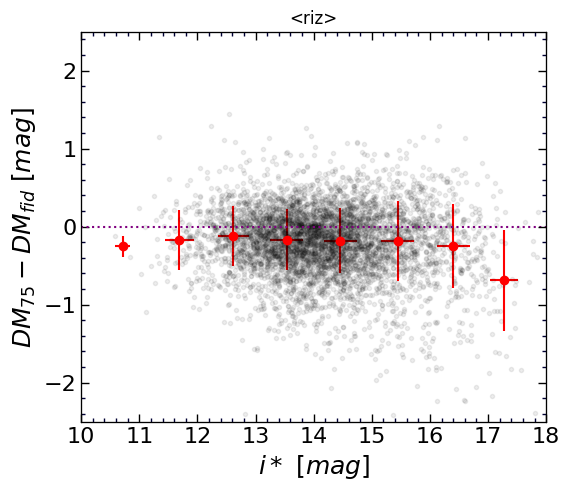

In [36]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


dff_ = dff[dff.V3k>4000]

X = dff_['i***'].values
Y = dff_.dDM.values
V = dff_.V3k.values

ax.plot(X, Y, 'k.', alpha=0.07)

X = X[np.abs(Y)<2]
Y = Y[np.abs(Y)<2]

for i in np.arange(10,18,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and ~np.isnan(xi) and ~np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
#         print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$i* \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)
# ax.set_ylabel(r'$log \/ (D_{75}/D_{fid})$', fontsize=18)


ax.plot([10,18], [0,0], ':', color='purple')

set_axes(ax, (10,18), (-2.5,2.5))

ax.set_title("<riz>")

In [37]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
try:
    dff['Mb'] = dff.Ms_riz + 1.33*(10**(np.log10(dff.Mass_HI)))
except:
    dff['Mb'] = dff.Ms_z + 1.33*(10**(np.log10(dff.Mass_HI)))
    
dff['logMb'] = np.log10(dff.Mb.values)

dff = dff.rename(columns={'DMriz_fid':'DMz_fid'})
try:
    dff = dff.rename(columns={'Ms_riz':'Ms_z'})
except:
    pass

dff[['DM_75', 'DMz_fid', 'Mass_HI', 'Ms_z', 'Mb', 'F21', 'eF21', 'Qs', 'DMav_z', 'eDM_z', 'eDM_z_adj']].to_csv("MLratio_z_distances_noCorrection.csv")

/home/ehsan/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(3.0542935524929256, 10.434247479407608)

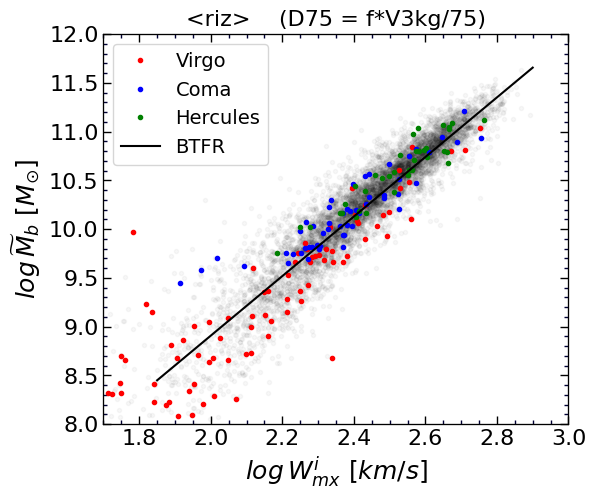

In [38]:
dff['Mass_HI'] = 2.356E5 * dff.F21 * (dff.D75**2)   # D75
dff['Mb'] = dff.Ms_z + 1.33*(10**(np.log10(dff.Mass_HI)+HI_corrector(mc, 0, dff.V3k.values)))
dff['logMb'] = np.log10(dff.Mb.values)

######################################################################
dff = dff.rename(columns={"1PGC": "PGC1"})

df_vrigo = dff[dff.PGC1==41220]
df_coma = dff[dff.PGC1==44715]
df_herc = dff[dff.PGC1==56962]

logW = dff.lgWmxi.values
logWe = dff.elgWi.values
logMass = dff.logMb.values


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

plt.plot(logW, logMass, '.', color='black', alpha=0.03) 


ax.plot(df_vrigo.lgWmxi, df_vrigo.logMb, 'r.', label='Virgo')
ax.plot(df_coma.lgWmxi, df_coma.logMb, 'b.', label='Coma')
ax.plot(df_herc.lgWmxi, df_herc.logMb, 'g.', label='Hercules')

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ \widetilde{M}_b \/\/ [M_{\odot}]$', fontsize=18)

set_axes(ax, (1.7,3), (8,12))
ax.set_title("<riz>    (D75 = f*V3kg/75)", fontsize=16)

w = np.linspace(1.85,2.9,100)
ax.plot(w, m0*(w-2.5) + zp_calib, 'k-', label='BTFR')

ax.legend(fontsize=14, loc=2)   

m0, b0

In [39]:
len(dff)

7096